#SNN Models
###In order to run the code in this notebook, you must download the ucscMFCDataset directory and stanfordMFCDataset.zip, which expands into the directory rocket4, from [Hugging Face](https://huggingface.co/datasets/adunlop621/Soil_MFC/tree/main), and store them in the same directory as this notebook. You can also find several pretrained models in the at this link, with the naming conventions described in the [README](https://github.com/jlab-sensing/MFC_Modeling#:~:text=Repository%20files%20navigation-,README,-MFC_Modeling)

In [ ]:
!pip install --upgrade hepml
!pip install arrow
!pip install keras_lr_finder
! pip install snntorch --quiet

In [ ]:
# reload modules before executing user code
#%load_ext autoreload
# reload all modules every time before executing Python code
#%autoreload 2
# render plots in notebook

# Misc imports
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))
import random
import statistics

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# torch imports
import torch
import torch.nn as nn

# snnTorch imports
import snntorch as snn
from snntorch import functional as SF
import snntorch.spikeplot as splt

# keras imports
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K



##Load and Format Dataset 1

In [ ]:
#Load teros data
import glob
teros_files = glob.glob("rocket4/TEROSoutput*.csv")
X = pd.DataFrame()
for f in teros_files:
  try:
    csv = pd.read_csv(f, index_col=False).dropna()
    X = pd.concat([X, csv])
  except:
    continue

In [ ]:
#Load power data
power_files = glob.glob("rocket4/soil*.csv")
y = pd.DataFrame()
for f in sorted(power_files, key=lambda x: int(x.split('.')[0].split('_')[-1])):
#in power_files:
  try:
    csv = pd.read_csv(f, on_bad_lines='skip', skiprows=10).dropna(how='all')
    csv = csv.rename({'Unnamed: 0': 'timestamp'}, axis='columns')
    y = pd.concat([y,csv])
  except:
    continue
y["timestamp"] = y["timestamp"].round(decimals = 1)

In [ ]:
#Convert current to amps, voltage to volts
y["I1L [10pA]"] = np.abs(y["I1L [10pA]"] * 1E-11)
y["V1 [10nV]"] = np.abs(y["V1 [10nV]"] * 1E-8)
y["I1H [nA]"] = np.abs(y["I1H [nA]"] * 1E-9)

In [ ]:
#Sort data by timestamp, convert to datetime
X = X.sort_values(['timestamp'])
y = y.sort_values(['timestamp'])
X['timestamp'] = pd.to_datetime(X['timestamp'], unit='s')
y['timestamp'] = pd.to_datetime(y['timestamp'], unit='s')

#Merge data by timestamp
uncut_df = pd.merge_asof(left=X,right=y,direction='nearest',tolerance=pd.Timedelta('1 sec'), on = 'timestamp').dropna(how='all')

#Isolate data from cell0
df = uncut_df.loc[uncut_df['sensorID'] == 0]

#Localize timestamp
df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

In [ ]:
#Use only data from after deployment date
#df = df.loc[(df['timestamp'] > '2021-09-24') & (df['timestamp'] < '2021-10-15')] #Future of Clean Computing Graph
#df = df.loc[(df['timestamp'] > '2021-06-24') & (df['timestamp'] < '2021-07-02')]
#df = df.loc[(df['timestamp'] > '2021-06-18')] #Two weeks after deployment
df = df.loc[(df['timestamp'] > '2021-06-04')] #Deployment date
#df = df.loc[(df['timestamp'] > '2021-06-25') & (df['timestamp'] < '2021-06-26')] #Small training set

#Power drop
#df = df.loc[(df['timestamp'] > '2021-11-01') & (df['timestamp'] < '2021-11-22')]

#Drop data outages
df = df.drop(df[(df.timestamp > '2021-11-11') & (df.timestamp < '2021-11-22 01:00:00')].index)
df = df.drop(df[(df.timestamp > '2022-01-27')].index)
#df = df.set_index('timestamp')
df = df[:-1]

In [ ]:
df = df.set_index('timestamp')

In [ ]:
#Get time since deployement
df['tsd'] = (df.index - df.index[0]).days
df['hour'] = (df.index).hour

In [ ]:
#Calculate power
df["power"] = np.abs(np.multiply(df.iloc[:, 7], df.iloc[:, 8]))
#df["power"] = np.abs(np.multiply(df["I1L [10pA]"], df["V1 [10nV]"]))

#Convert to nW
df['power'] = df['power']*1E9

In [ ]:
#Convert to 10 nanoamps, 10 microvolts
df["I1L [10pA]"] = np.abs(df["I1L [10pA]"] * 1E8)
df["V1 [10nV]"] = np.abs(df["V1 [10nV]"] * 1E5)
df["I1H [nA]"] = np.abs(df["I1H [nA]"] * 1E8)

In [ ]:
df = df.reset_index()

In [ ]:
#Add power time series
df['power - 1h'] = df['power'].shift(1).dropna()
df['power - 2h'] = df['power'].shift(2).dropna()
df['power - 3h'] = df['power'].shift(3).dropna()
#df['power - 2h'] = df['power'].shift(2).dropna()
#df['previous_power - 3'] = df['power'].shift(3).dropna()
#df['previous_power - 4'] = df['power'].shift(4).dropna()

#Add teros time series
df['EC - 1h'] = df['EC'].shift(1).dropna()
df['EC - 2h'] = df['EC'].shift(2).dropna()
df['EC - 3h'] = df['EC'].shift(3).dropna()

df['temp - 1h'] = df['temp'].shift(1).dropna()
df['temp - 2h'] = df['temp'].shift(2).dropna()
df['temp - 3h'] = df['temp'].shift(3).dropna()

df['raw_VWC - 1h'] = df['raw_VWC'].shift(1).dropna()
df['raw_VWC - 2h'] = df['raw_VWC'].shift(2).dropna()
df['raw_VWC - 3h'] = df['raw_VWC'].shift(3).dropna()

#Add voltage and current time series
df['V1 - 1h'] = df['V1 [10nV]'].shift(1).dropna()
df['V1 - 2h'] = df['V1 [10nV]'].shift(2).dropna()
df['V1 - 3h'] = df['V1 [10nV]'].shift(3).dropna()

df['I1L - 1h'] = df['I1L [10pA]'].shift(1).dropna()
df['I1L - 2h'] = df['I1L [10pA]'].shift(2).dropna()
df['I1L - 3h'] = df['I1L [10pA]'].shift(3).dropna()

df['I1H - 1h'] = df['I1H [nA]'].shift(1).dropna()
df['I1H - 2h'] = df['I1H [nA]'].shift(2).dropna()
df['I1H - 3h'] = df['I1H [nA]'].shift(3).dropna()
df = df.dropna()

In [ ]:
#df = df.rename(columns={'power': 'power [μW]'})
df = df.rename(columns={'I1L [10pA]': 'Current (uA)', 'V1 [10nV]' : 'Voltage (mV)', 'power' : 'Power (uW)'})
df = df.set_index('timestamp')

In [ ]:
#New runtime calculation
import math
from dateutil import parser
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

def internal_R_v3(R=2000): #return internal resistance of v3 cells in ohms
    #https://www.jstage.jst.go.jp/article/jwet/20/1/20_21-087/_pdf
    v0_oc = 48.5e-3 #48.5 mV
    v0_cc = 4.8e-3
    v0_r = R*((v0_oc/v0_cc)-1)

    v1_oc = 43.8e-3
    v1_cc = 20.9e-3
    v1_r = R*((v1_oc/v1_cc)-1)

    v2_oc = 45.2e-3
    v2_cc = 23.5e-3
    v2_r = R*((v2_oc/v2_cc)-1)

    return (v0_r+v1_r+v2_r)/3

def internal_R_v0(R=2000): #return internal resistance of v0 cells in ohms
    v3_oc = 41.7e-3 #41.7mV
    v3_cc = 5.1e-3
    v3_r = R*((v3_oc/v3_cc)-1)

    v4_oc = 48.7e-3
    v4_cc = 16.8e-3
    v4_r = R*((v4_oc/v4_cc)-1)

    v5_oc = 39.1e-3
    v5_cc = 16.9e-3
    v5_r = R*((v5_oc/v5_cc)-1)

    return (v3_r+v4_r+v5_r)/3

def SMFC_current(v, R):
    return v/R

#MODEL
def cap_leakage(E_cap_tn, timestep):
    #Spec for KEMET T491
    return 0.01e-6 * E_cap_tn * timestep

def Matrix_Power(V, R):
    #efficiency interpolated from https://www.analog.com/media/en/technical-documentation/data-sheets/ADP5091-5092.pdf
    #given I_in = 100 uA and SYS = 3V
    #V is the voltage (V) of the SMFC we captured
    #R is the resistance (ohms) of the load we used to get that voltage trace
    #Eta = -292.25665*V**4 + 784.30311*V**3 - 770.71691*V**2 + 342.00502*V + 15.83307
    #Eta = Eta/100
    Eta = 0.60
    Pmax = (V**2)/R
    Pout = Eta*Pmax
    #assert((Eta > 0) & (Eta < 1))
    #assert(Pout < 12000e-6)
    return Pout

def update_capEnergy(e0, V_applied, R, C, dt):
    # e0: initial energy stored
    # V_applied: voltage from SMFC
    # R: internal resistance of SMFC
    # C: capacitance of capacitor
    # dt: time step since last data point
    e_cap = e0 + Matrix_Power(V_applied, R)*dt - cap_leakage(e0, dt)
    v_cap = math.sqrt(2*e_cap/C)
    if e_cap < 0: #Not charging if leakage is greater than energy
        e_cap = 0

    return e_cap, v_cap #output final e and v

def Advanced_energy():
    #Now representing "Advanced"
    #startup time of 2500 ms
    t = 2500e-3
    e = 2.4 * 128e-3 * t
    e_startup = 2.4 * 128e-3 * 5e-3
    return e+e_startup

def Minimal_energy():
    #Now representing "Minimal"
    t = 0.888e-3 #tentative time
    e = 0.9 * 4.8e-3 * t #this uses average current
    e_startup = 0#assume negligible, no known startup time given
    return  e + e_startup

def Analog_energy():
    #Now representing Analog
    t = 1e-3 #estimated operating time
    e = 0.11 * 2.15e-6 * t
    e_startup = 0 #analog device, no startup needed :)
    return e + e_startup

#STEP 3:
# For each day:
#   on_Minimal, on_Advanced, on_Analog = 0
#   For each time step (like every 60 s given our logging freq):
#       - Update the energy in our capacitor (put fcn in models.py) given (1) input voltage, (2) time step, (3) capacitance (prob 10 uF), this will be an integral
#       - Check if energy is enough to turn on (1) 1 uJ load, (2) 10 uJ load, and (3) 20 uJ load (will tweak later to reflect real energy cost of each system)
#       - If so, add to on_Minimal, on_Advanced, and on_Analog and reset capacitor energy to 0 J (might tweak this value)
#   Append on_Minimal, on_Advanced, on_Analog to on_Minimal_list, on_Advanced_list, on_Analog_list. This will be a list of how many sensor readings we are able to take with each of these systems every day given the energy we got
#STEP 4: Visualize the daily # of readings with 3 bar graphs, y axis is # of readings and x axis is days.
#   - Given 3 lists of integer values, plot them on bar graphs

def group_util(test_date1, test_date2, N):
    diff = (test_date2 - test_date1) / N
    return [test_date1 + diff * idx for idx in range(N)] + [test_date2]

def oracle_simulate(v_list, C_h):
    #Calculate maximum energy
    total_E = 0
    for i in range(len(v_list) - 1):
        t = (v_list.index[i+1] - v_list.index[i]).total_seconds()
        if t > 180:
          print("Discontinuity")
          print(v_list.index[i+1], v_list.index[i])
          print(v_list['V1 [mV]'][i+1], v_list['V1 [mV]'][i])
          #total_E, ignore = update_capEnergy(total_E, V_applied=(v_list['V1 [mV]'][i+1] + v_list['V1 [mV]'][i])/2, R=internal_R_v0(), C=C_h[0], dt = t)
        else:
          total_E, ignore = update_capEnergy(total_E, V_applied=max(v_list['V1 [mV]'][i], v_list['V1 [mV]'][i+1]), R=internal_R_v0(), C=C_h[0], dt = t)
    print("Oracle activations:", math.floor(total_E/Minimal_energy()))
    return(math.floor(total_E/Minimal_energy()))

def naive_simulate(t_list, v_list, v_list_naive, v_list_fine, C_h):
    # t_list: list of decimal time stamps in unit of days (e.g. 71.85893518518519 day), same length as v_list
    # v_list: list of voltage values from SFMC
    # C_h: capacitance of the capacitor being filled up by harvester

    #assume capacitor is completely discharged at start
    e_minimal_stored = 0
    e_minimal_stored_theo = 0

    #Initialize evaluation metrics
    false_act = 0
    max_act = 0
    pred_act = 0
    succ_act = 0

    total_E = 0
    total_E_naive = 0

    #Calculate maximum energy
    #for i in range(len(v_list_fine) - 1):
    #    t = (v_list_fine.index[i+1] - v_list_fine.index[i]).total_seconds()
    #    total_E, ignore = update_capEnergy(total_E, V_applied=v_list_fine['V1 [10nV]'][i], R=internal_R_v0(), C=C_h[0], dt = t)
    #print(total_E/Minimal_energy())
    v = v_list_naive.mean()
    #for each voltage data point
    for jj in range(len(v_list) - 1): #last data point was at 71.85893518518519 day
        t = (v_list.index[jj+1] - v_list.index[jj]).total_seconds()
        if t <= time_frame_seconds:
          #Total predicted vs. actual energy stored
          #Predict energy stored during scheduled sub-interval
          total_E, ignore = update_capEnergy(total_E, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
          total_E_naive, ignore = update_capEnergy(total_E_naive, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = t)

          E_Minimal_pred, v_minimal_pred = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = t) #set dt as length of prediction interval, in seconds
          pred_act += math.floor(E_Minimal_pred/Minimal_energy()) #Update number of activations predicted
          itn = 0
          if math.floor(E_Minimal_pred/Minimal_energy()) > 0:
              minimal_intervals = [date for date in group_util(v_list.index[jj], v_list.index[jj] + timedelta(seconds=t), math.floor(E_Minimal_pred/Minimal_energy()))]
              #Calculate desired interval
              int_len = time_frame_seconds /  math.floor(E_Minimal_pred/Minimal_energy())
              for i in range(len(minimal_intervals) - 1):
                  #Determine actual energy stored during scheduled sub-interval
                  start = v_list_fine.index.searchsorted(minimal_intervals[i])
                  end =  v_list_fine.index.searchsorted(minimal_intervals[i+1])

                  E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v_list_fine.iloc[start:end]['V1 [mV]'].mean(), R=internal_R_v0(), C=C_h[0], dt = int_len)
                  if not math.isnan(v_list_fine.iloc[start:end]['V1 [mV]'].mean()):
                    if E_Minimal < Minimal_energy():
                        false_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                        itn += 1

                    elif E_Minimal >= Minimal_energy():
                        succ_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                        itn+= 1

                    else:
                      print('Error')
                      print(e_minimal_stored, v)

                  #Unit test
                  #else:
                  #  print("?")
                  #  print(v_list_fine.index[start])
                  #  print(v_list_fine.index[end])
                  #  print(minimal_intervals[i], minimal_intervals[i+1])

              #Unit test
              #if itn != math.floor(E_Minimal_pred/Minimal_energy()):
              #    print("itn not matching")
              #    print(itn, math.floor(E_Minimal_pred/Minimal_energy()))
              #    continue

          else:
              e_minimal_stored, ignore = update_capEnergy(e_minimal_stored, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
              #Added this
              #start = v_list_fine.index.searchsorted(v_list.index[jj])
              #end =  v_list_fine.index.searchsorted(v_list.index[jj+1])
              #for h in range(start, end):
              #    v = v_list_fine.iloc[h]['V1 [mV]']
              #    interval_length = ((v_list_fine.index[h+1]) - (v_list_fine.index[h])).total_seconds()
              #    E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)
              #    e_minimal_stored = E_Minimal


        else:
          print("It's over 9000!", v_list.index[jj], v_list.index[jj+1])

    print("Naive total_E activations:", total_E/Minimal_energy())
    print("Naive total_E_pred activations:", total_E_naive/Minimal_energy())
    return pred_act, false_act, succ_act, total_E_naive

def getMax(c_list, input_list):
    max_value = max(input_list)
    i = [index for index, item in enumerate(input_list) if item == max_value][0]
    return i, max_value, c_list[i]


#SMFC
import csv
from collections import defaultdict
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from datetime import datetime

def butter_lowpass(cutoff, fs, order=5):
        return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def getMFC_data(y_test, test_pred):
    unix_time = y_test.index
    d0 = unix_time[0]
    days = []
    for d in unix_time:
        day = d
        day_from_start = day-d0
        decimal_day = day_from_start.total_seconds()/(24 * 3600)
        days.append(decimal_day)

    return days

def simulate(t_list, v_list, v_list_pred, v_list_fine, C_h):
    # t_list: list of decimal time stamps in unit of days (e.g. 71.85893518518519 day), same length as v_list
    # v_list: list of voltage values from SFMC
    # C_h: capacitance of the capacitor being filled up by harvester

    #assume capacitor is completely discharged at start
    e_minimal_stored = 0
    e_minimal_stored_theo = 0

    #Initialize evaluation metrics
    false_act = 0
    max_act = 0
    pred_act = 0
    succ_act = 0

    total_E = 0
    total_E_pred = 0

    #Calculate maximum energy
    #for i in range(len(v_list_fine) - 1):
    #    t = (v_list_fine.index[i+1] - v_list_fine.index[i]).total_seconds()
    #    total_E, ignore = update_capEnergy(total_E, V_applied=v_list_fine['V1 [10nV]'][i], R=internal_R_v0(), C=C_h[0], dt = t)
    #print(total_E/Minimal_energy())
    #for each voltage data point
    for jj in range(len(v_list) - 1): #last data point was at 71.85893518518519 day
        t = (v_list.index[jj+1] - v_list.index[jj]).total_seconds()
        total_E, ignore = update_capEnergy(total_E, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
        total_E_pred, ignore = update_capEnergy(total_E_pred, V_applied=v_list_pred[jj], R=internal_R_v0(), C=C_h[0], dt = t)
        if t <= time_frame_seconds:
          #Total predicted vs. actual energy stored
          #Predict energy stored during scheduled sub-interval
          E_Minimal_pred, v_minimal_pred = update_capEnergy(e_minimal_stored, V_applied=v_list_pred[jj], R=internal_R_v0(), C=C_h[0], dt = t) #set dt as length of prediction interval, in seconds
          pred_act += math.floor(E_Minimal_pred/Minimal_energy()) #Update number of activations predicted
          itn = 0
          if math.floor(E_Minimal_pred/Minimal_energy()) > 0:
              minimal_intervals = [date for date in group_util(v_list_pred.index[jj], v_list_pred.index[jj] + timedelta(seconds=t), math.floor(E_Minimal_pred/Minimal_energy()))]
              #Calculate desired interval
              int_len = time_frame_seconds /  math.floor(E_Minimal_pred/Minimal_energy())
              for i in range(len(minimal_intervals) - 1):
                  #Determine actual energy stored during scheduled sub-interval
                  start = v_list_fine.index.searchsorted(minimal_intervals[i])
                  end =  v_list_fine.index.searchsorted(minimal_intervals[i+1])
                  v = v_list_fine.iloc[start:end]['V1 [mV]'].mean()

                  #interval_length = ((v_list_fine.index[end]) - (v_list_fine.index[start])).total_seconds()
                  #if interval_length > int_len:
                  #  print('interval_length > int_len')
                  #  print('interval_length, int_len:', interval_length, int_len)
                  #  print(v_list_fine.index[start], v_list_fine.index[end])
                  #else:
                  #  print('interval_length <= int_len')
                  #  print('interval_length, int_len:', interval_length, int_len)
                  #  print(v_list_fine.index[start], v_list_fine.index[end])

                  E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = int_len)
                  if not math.isnan(v_list_fine.iloc[start:end]['V1 [mV]'].mean()):
                    if E_Minimal < Minimal_energy():
                        false_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                        itn += 1

                    elif E_Minimal >= Minimal_energy():
                        succ_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                        itn+= 1

                    else:
                      print('Error')
                      print(e_minimal_stored, v)

                  #Unit test
                  #else:
                  #  print("?")
                  #  print(v_list_fine.index[start])
                  #  print(v_list_fine.index[end])
                  #  print(minimal_intervals[i], minimal_intervals[i+1])

              #Unit test
              #if itn != math.floor(E_Minimal_pred/Minimal_energy()):
              #    print("itn not matching")
              #    print(itn, math.floor(E_Minimal_pred/Minimal_energy()))
              #    continue

          else:
              e_minimal_stored, ignore = update_capEnergy(e_minimal_stored, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
              #Added this
              #start = v_list_fine.index.searchsorted(v_list.index[jj])
              #end =  v_list_fine.index.searchsorted(v_list.index[jj+1])
              #for h in range(start, end):
              #    v = v_list_fine.iloc[h]['V1 [mV]']
              #    interval_length = ((v_list_fine.index[h+1]) - (v_list_fine.index[h])).total_seconds()
              #    E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)
              #    e_minimal_stored = E_Minimal


        else:
          print("It's over 9000!", v_list.index[jj], v_list.index[jj+1])

    print("Runtime total_E activations:", total_E/Minimal_energy())
    print("Runtime total_E_pred activations:", total_E_pred/Minimal_energy())
    return pred_act, false_act, succ_act, total_E, total_E_pred

## Specify Device so we can use GPU

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Network Architecture

In [ ]:
beta = 0.9

# old design network
# model = Sequential()
# model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(3))
# model.compile(loss=quantile_loss, metrics=['mape'], optimizer='adam')

# Define Network
class Net(nn.Module):
    def __init__(self, num_inputs, num_steps):
        super().__init__()

        self.num_inputs = num_inputs
        self.num_steps = num_steps

        num_hidden1 = 200

        # layer 1
        self.slstm1 = snn.SLSTM(num_inputs, num_hidden1, threshold = 0.25)

        # layer 2
        self.fc1 = torch.nn.Linear(in_features=num_hidden1, out_features=100)
        self.lif1 = snn.Leaky(beta=beta, threshold = 0.5)

        # randomly initialize decay rate for output neuron
        beta_out = random.uniform(0.5, 1)

        # layer 2
        self.fc2 = torch.nn.Linear(in_features=100, out_features=3)
        self.lif2 = snn.Leaky(beta=beta_out, learn_beta=True, reset_mechanism="none")


    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        syn1, mem1 = self.slstm1.reset_mem()
        mem2 = self.lif1.reset_mem()
        mem3 = self.lif2.reset_mem()

        # Record the final layer
        spk1_rec = []
        spk2_rec = []
        spk3_rec = []
        mem_rec = []

        for step in range(self.num_steps):
            spk1, syn1, mem1 = self.slstm1(x.flatten(1), syn1, mem1)
            spk2, mem2 = self.lif1(self.fc1(spk1), mem2)
            spk3, mem3 = self.lif2(self.fc2(spk2), mem3)

            # Append the Spike and Membrane History
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            spk3_rec.append(spk3)
            mem_rec.append(mem3)

        return torch.stack(spk1_rec), torch.stack(spk2_rec), torch.stack(spk3_rec), torch.stack(mem_rec)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
X_train, X_test = train_test_split(pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"],df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1), test_size=0.3, shuffle=False)
y_train, y_test = train_test_split(pd.concat([df['Power (uW)'], df['Voltage (mV)'], df['Current (uA)']], axis = 1), test_size=0.3, shuffle=False)

In [ ]:
X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

In [ ]:
#All Data (For Type 1 and 2 Models)
X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"],df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1)

#Electricity Data Omitted (For Type 1A and 2A Models)
#X = pd.concat([df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1)

#Environmental Data Omitted (For Type 1B and 2B Models)
#X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"]], axis = 1)

y = pd.concat([df["Power (uW)"], df['Voltage (mV)'], df['Current (uA)']], axis = 1)

## 2. Train and Load Models

###2.1 Train new SNN model

In [ ]:
power_mape = []
voltage_mape = []
current_mape = []

E_actual_list = []
E_pred_list = []

max_act_list = []
pred_act_list = []
succ_act_list = []

pred_act_naive_list = []
false_act_naive_list = []
succ_act_naive_list = []

#Set parameters
batchsize_list = [300, 150, 50, 20, 8]
time_frame_list = ['3min', '5min', '15min', '30min', '60min']
time_frame_seconds_list = [180, 300, 900, 1800, 3600]
n = 0

for j in range(len(batchsize_list)):
    n += 1
    if n == 1: #Select which timescales to train for
        #Normalize Data
        X_normalized = ((X - X.min()) / (X.max() - X.min()))

        #Split train and test sets
        X_train, X_test = train_test_split(X_normalized, test_size=0.3, shuffle=False)
        y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

        X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
        y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

        batchsize = batchsize_list[j]
        time_frame = time_frame_list[j]
        time_frame_seconds = time_frame_seconds_list[j]

        print(time_frame)

        #Resample data
        X_train = X_train.resample(time_frame).mean().dropna()
        X_valid = X_valid.resample(time_frame).mean().dropna()
        X_test = X_test.resample(time_frame).mean().dropna()

        y_train = y_train.resample(time_frame).mean().dropna()
        y_valid = y_valid.resample(time_frame).mean().dropna()
        y_test = y_test.resample(time_frame).mean().dropna()

        #Reshape data
        X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
        X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # convert to tensor
        X_train = torch.tensor(X_train)
        y_train = torch.tensor(y_train.values)
        X_test = torch.tensor(X_test)
        y_test = torch.tensor(y_test.values)

        # make datasets
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

        # Define the number of time steps for the spiking
        num_steps = 50
        num_inputs = X_train.shape[2]

        # create new inctance of the SNN Class
        model = Net(num_inputs, num_steps).to(device)

        # define optimizer
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

        # define loss function
        def quantile_loss(y_true, y_pred, quantile=0.5):
            error = y_true - y_pred
            loss = torch.mean(torch.max(quantile * error, (quantile - 1) * error))
            return loss
        loss_fn = quantile_loss
        #loss_fn = torch.nn.MSELoss()
        #loss_fn = torch.nn.L1Loss()

        # initialize histories
        loss_hist = []
        avg_loss_hist = []
        acc_hist = []
        mape_hist = []
        num_epochs = 25

        # put model into train mode
        model.train()

        # Train Loop
        for epoch in range(num_epochs):
            for i, (data, targets) in enumerate(iter(train_loader)):
                # move to device
                data = data.to(device)
                targets = targets.to(device)

                # change to floats
                data = data.float()
                targets = targets.float()

                # run forward pass
                _, _, _, mem = model(data)
                # calculate loss
                loss_val = loss_fn(mem[-1], targets)

                # calculate and store MAPE Loss
                mem_numpy = mem.cpu().detach().numpy()
                #mem_numpy = mem.detach().numpy()
                targets_numpy = targets.cpu().detach().numpy()
                #targets_numpy = targets.detach().numpy()
                mape_hist.append(MAPE(mem_numpy[-1], targets_numpy))
                power_mape.append(MAPE(mem_numpy[-1][:,0], targets_numpy[:,0]))
                voltage_mape.append(MAPE(mem_numpy[-1][:,1], targets_numpy[:,1]))
                current_mape.append(MAPE(mem_numpy[-1][:,2], targets_numpy[:,2]))

                # Gradient calculation + weight update
                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

                # Store loss history for future plotting
                loss_hist.append(loss_val.item())

                if i%10 == 0:
                    print(f"Epoch {epoch}, Iteration {i} Train Loss: {loss_val.item():.2f}")
                if len(loss_hist) > 100:
                    avg_loss_hist.append(sum(loss_hist[-100:])/len(loss_hist[-100:]))
                else:
                    avg_loss_hist.append(0)

            if len(loss_hist) > 100:
                print(f'New Epoch! Avg loss for the last 100 iterations: {avg_loss_hist[-1]}')

In [ ]:
#Save model
checkpoint = {'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}
torch.save(checkpoint, 'snn_30min_quant50.pth')
!mv snn_30min_quant50.pth 'trained_models'

###2.2 TSRV on Type 1 Models

In [ ]:
power_mape = []
voltage_mape = []
current_mape = []

E_actual_list = []
E_pred_list = []

max_act_list = []
pred_act_list = []
succ_act_list = []

pred_act_naive_list = []
false_act_naive_list = []
succ_act_naive_list = []

#Set parameters
batchsize = 8
time_frame = '60min'
time_frame_seconds = 3600
n = 0
splits = TimeSeriesSplit(n_splits=4)
for train_index, test_index in splits.split(X):
    n += 1
    if n >= 1:
        #Split train and test sets
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
        y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

        #Set dataset bounds
        train_bound_lower = y_train.index[0]
        train_bound_upper = y_train.index[-1]
        valid_bound_lower = y_valid.index[0]
        valid_bound_upper = y_valid.index[-1]
        test_bound_lower = y_test.index[0]
        test_bound_upper = y_test.index[-1]

        #Resample data
        X_train = X_train.resample(time_frame).mean().dropna()
        X_valid = X_valid.resample(time_frame).mean().dropna()
        X_test = X_test.resample(time_frame).mean().dropna()

        y_train = y_train.resample(time_frame).mean().dropna()
        y_valid = y_valid.resample(time_frame).mean().dropna()
        y_test = y_test.resample(time_frame).mean().dropna()

        #Reshape data
        X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
        X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # convert to tensor
        X_train = torch.tensor(X_train)
        y_train_index_labels = y_train.index
        y_train_column_labels = y_train.columns
        y_train = torch.tensor(y_train.values)

        X_test = torch.tensor(X_test)
        y_test_index_labels = y_test.index
        y_test_column_labels = y_test.columns
        y_test = torch.tensor(y_test.values)

        # make datasets
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

        # Define the number of time steps for the spiking
        num_steps = 50
        num_inputs = X_train.shape[2]

        # create new inctance of the SNN Class
        model = Net(num_inputs, num_steps).to(device)

        # define optimizer
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

        # define loss function
        def quantile_loss(y_true, y_pred, quantile=0.05):
            error = y_true - y_pred
            loss = torch.mean(torch.max(quantile * error, (quantile - 1) * error))
            return loss
        loss_fn = quantile_loss

        # initialize histories
        loss_hist = []
        avg_loss_hist = []
        acc_hist = []
        num_epochs = 25

        # put model into train mode
        model.train()

        # Train Loop
        for epoch in range(num_epochs):
            for i, (data, targets) in enumerate(iter(train_loader)):
                # move to device
                data = data.to(device)
                targets = targets.to(device)

                # change to floats
                data = data.float()
                targets = targets.float()

                _, _, _, mem = model(data)

                loss_val = loss_fn(mem[-1], targets)

                # Gradient calculation + weight update
                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

                # Store loss history for future plotting
                loss_hist.append(loss_val.item())

                # Update loss plot
                # update_loss_plot(loss_hist)

                if i%10 == 0:
                    print(f"Epoch {epoch}, Iteration {i} Train Loss: {loss_val.item():.2f}")
                if len(loss_hist) > 100:
                    avg_loss_hist.append(sum(loss_hist[-100:])/len(loss_hist[-100:]))
                else:
                    avg_loss_hist.append(0)

            if len(loss_hist) > 100:
                print(f'New Epoch! Avg loss for the last 100 iterations: {avg_loss_hist[-1]}')

        # predictions
        model.eval()

        train_pred = []
        test_pred = []
        with torch.no_grad():
            for data, target in train_dataset:
                data = data.to(device)
                data = data.float()
                _, _, _, train_mem = model(data)
                train_pred.append(train_mem[-1])

            for data, target in test_dataset:
                data = data.to(device)
                data = data.float()
                _, _, _, test_mem = model(data)
                test_pred.append(test_mem[-1])

        # Convert to numpy
        train_pred = torch.cat(train_pred, dim=0)
        train_pred = train_pred.numpy()
        test_pred = torch.cat(test_pred, dim=0)
        test_pred = test_pred.numpy()

        # convert tensors back to dataframe
        y_test = pd.DataFrame(y_test, index=y_test_index_labels, columns=y_test_column_labels)
        y_train = pd.DataFrame(y_test, index=y_train_index_labels, columns=y_test_column_labels)

        #Prepare data for runtime simulation
        y_test['power pred'] = test_pred[:, 0]
        y_test['V1 [mV] pred'] = test_pred[:, 1]
        y_test['I1L [μA] pred'] = test_pred[:, 2]

        days  = getMFC_data(y_test, test_pred)

        v_test = df.loc[(((df.index >= test_bound_lower)) & (df.index <= test_bound_upper))]['V1 [mV]']
        v_test = v_test.drop(v_test[(v_test.index > '2021-11-11') & (v_test.index < '2021-11-22 01:00:00')].index)
        v_test = pd.DataFrame(v_test)/1E5
        v_avg_true = v_test['V1 [mV]'].resample(time_frame).mean().dropna()
        v_avg_pred = y_test['V1 [mV] pred']/1E5
        C0 = [0.007000000000000006, 0.007000000000000006, 0.007000000000000006]

        #Remove first and last entries of averaged data to prevent overestimation of available energy
        v_avg_true = v_avg_true[1:][:-1]
        v_avg_pred = v_avg_pred[1:][:-1]

        #Run oracle model
        max_act = oracle_simulate(v_test, C0)

        #Call simulate function
        pred_act, false_act, succ_act, total_E, total_E_pred = simulate(days, v_avg_true, v_avg_pred, v_test, C0)

        #Run naive model
        v_valid = df.loc[(((df.index >= valid_bound_lower)) & (df.index < valid_bound_upper))]['V1 [mV]']/1E5
        pred_act_naive, false_act_naive, succ_act_naive, total_E = naive_simulate(days, v_avg_true, v_valid, v_test, C0)
        print("Dataset, train set, and test set size:", len(y_train) + len(y_valid) + len(y_test), len(y_train), len(y_test))
        print('Timeframe:', time_frame)

        print('Minimal Application')
        print("Naive vs. DL succesful activations:", succ_act/succ_act_naive)
        #print('Predicted vs. Actual percent difference: %.3f%%' % ((total_E * 100 / total_E_pred) - 100))
        print('Maximum possible activations:', max_act)
        print('Predicted activations:', pred_act)
        print('Successful activations: %d, %.3f%%' % (succ_act, succ_act * 100/pred_act))
        print('Failed activations: %d, %.3f%%' % (false_act, false_act * 100/pred_act))
        print('Missed activations: %d, %.3f%%' % (max_act - succ_act, (max_act - succ_act) * 100/max_act))

        #Naive model
        print('Naive predicted activations (usual actual energy average):', pred_act_naive)
        print('Naive successful activations (usual actual energy average): %d, %.3f%%' % (succ_act_naive, succ_act_naive * 100/pred_act_naive))
        print('Naive failed activations (usual actual energy average): %d, %.3f%%' % (false_act_naive, false_act_naive * 100/pred_act_naive))
        print('Naive missed activations (usual actual energy average): %d, %.3f%%' % (max_act - succ_act_naive, (max_act - succ_act_naive) * 100/max_act))


        print('Voltage overestimation rate: %.3f%%' % ((y_test['V1 [mV]'].values <= y_test['V1 [mV] pred']).mean() * 100))
        print("Test MAPE power: %3f" %  MAPE(y_test['power'].values.ravel(), y_test['power pred']))
        print("Test MAPE voltage: %3f" % MAPE(y_test['V1 [mV]'], y_test['V1 [mV] pred']))
        print("Test MAPE current: %3f" % MAPE(y_test['I1L [μA]'], y_test['I1L [μA] pred']))

##3. Graph Selected Data

###3.1 Load and graph pretrained SNN models

In [ ]:
from keras.models import load_model

time_frame = '60min'
batchsize = 8

X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"],df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1)
#X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"], df["tsd"], df["hour"]], axis = 1)
y = pd.concat([df["Power (uW)"], df['Voltage (mV)'], df['Current (uA)']], axis = 1)

#Normalize Data
X_normalized = ((X - X.min()) / (X.max() - X.min()))

#Split train and test sets
X_train, X_test = train_test_split(X_normalized, test_size=0.3, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

#Resample data

X_valid = X_valid.resample(time_frame).mean().dropna()
y_valid = y_valid.resample(time_frame).mean().dropna()

X_test = X_test.resample(time_frame).mean().dropna()
y_test = y_test.resample(time_frame).mean().dropna()

#Define mv1
mv1 = y_valid

#Reshape data
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# convert to tensor
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train.values)
X_valid = torch.tensor(X_valid)
y_valid = torch.tensor(y_valid.values)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test.values)

# make datasets
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

num_steps = 50
num_inputs = X_train.shape[2]

# create new inctance of the SNN Class
model = Net(num_inputs, num_steps).to(device)

model.load_state_dict(torch.load("trained_models/snn_60min_quant50", map_location=torch.device('cpu')))
model.eval()
actuals = []
predictions = []

with torch.no_grad():
    for data, targets in valid_loader:

        # prepare data
        data = data.to(device)
        targets = targets.to(device)

        data = data.float()
        targets = targets.float()

        _, _, _, output = model(data)

        output = output.cpu()
        output = output.squeeze(1).detach()

        prediction = output[-1]

        actuals.append(targets)
        predictions.append(prediction)

# Convert lists to tensors
actuals = torch.cat(actuals, dim=0)
predictions = torch.cat(predictions, dim=0)

mv1["power_pred_med"] = predictions[:, 0]
mv1["voltage_pred_med"] = predictions[:, 1]
mv1["current_pred_med"] = predictions[:, 2]
#mv1 = mv1.loc[(mv1.index > '2022-01-04') & (mv1.index < '2022-01-06')]
mv1 = mv1.loc[(mv1.index > '2021-12-12') & (mv1.index < '2021-12-14')]
mv2 = mv1

###3.2 SNN Peformance Metrics

In [ ]:
from keras.models import load_model

#Set parameters
batchsize_list = [300, 150, 50, 20, 8]
time_frame_list = ['3min', '5min', '15min', '30min', '60min']
time_frame_seconds_list = [180, 300, 900, 1800, 3600]
n = 0

snn_power_mape_list = []
snn_volt_mape_list = []
snn_curr_mape_list = []

for j in range(len(batchsize_list)):
    batchsize = batchsize_list[j]
    time_frame = time_frame_list[j]
    time_frame_seconds = time_frame_seconds_list[j]

    X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"],df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1)
    #X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"], df["tsd"], df["hour"]], axis = 1)
    y = pd.concat([df["Power (uW)"], df['Voltage (mV)'], df['Current (uA)']], axis = 1)

    #Normalize Data
    X_normalized = ((X - X.min()) / (X.max() - X.min()))

    #Split train and test sets
    X_train, X_test = train_test_split(X_normalized, test_size=0.3, shuffle=False)
    y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

    X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
    y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

    #Calculate actual energy generated in test set
    E_actual = 0
    for i in range(len(y_test) - 1):
      t = (y_test.index[i+1] - y_test.index[i]).total_seconds()
      if t < 180:
        E_actual += y_test['Power (uW)'][i] * t

    #Resample data

    X_valid = X_valid.resample(time_frame).mean().dropna()
    y_valid = y_valid.resample(time_frame).mean().dropna()

    X_test = X_test.resample(time_frame).mean().dropna()
    y_test = y_test.resample(time_frame).mean().dropna()

    #Define mv1
    mv1 = y_test

    #Reshape data
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # convert to tensor
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train.values)
    X_valid = torch.tensor(X_valid)
    y_valid = torch.tensor(y_valid.values)
    X_test = torch.tensor(X_test)
    y_test = torch.tensor(y_test.values)

    # make datasets
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    test_dataset = TensorDataset(X_test, y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

    num_steps = 50
    num_inputs = X_train.shape[2]

    # create new inctance of the SNN Class
    model = Net(num_inputs, num_steps).to(device)

    file = 'trained_models/snn_' + time_frame_list[j] + '_quant50.pth'
    print(file)

    checkpoint = torch.load(file, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])

    #model.load_state_dict(torch.load(file, map_location=torch.device('cpu'))['model_state_dict'])
    model.eval()
    actuals = []
    predictions = []

    with torch.no_grad():
        for data, targets in test_loader:

            # prepare data
            data = data.to(device)
            targets = targets.to(device)

            data = data.float()
            targets = targets.float()

            _, _, _, output = model(data)

            output = output.cpu()
            output = output.squeeze(1).detach()

            prediction = output[-1]

            actuals.append(targets)
            predictions.append(prediction)

    # Convert lists to tensors
    actuals = torch.cat(actuals, dim=0)
    predictions = torch.cat(predictions, dim=0)

    mv1["power_pred_med_" + time_frame_list[j]] = predictions[:, 0].numpy()
    mv1["voltage_pred_med_" + time_frame_list[j]] = predictions[:, 1].numpy()
    mv1["current_pred_med_" + time_frame_list[j]] = predictions[:, 2].numpy()

    print('Voltage overestimation rate: %.3f%%' % ((mv1['Voltage (mV)'].values <= mv1["voltage_pred_med_" + time_frame_list[j]]).mean() * 100))
    print("Test MAPE power: %3f" %  MAPE(mv1['Power (uW)'].values.ravel(), mv1["power_pred_med_" + time_frame_list[j]]))
    print("Test MAPE voltage: %3f" % MAPE(mv1['Voltage (mV)'], mv1["voltage_pred_med_" + time_frame_list[j]]))
    print("Test MAPE current: %3f" % MAPE(mv1['Current (uA)'], mv1["current_pred_med_" + time_frame_list[j]]))

    E_pred = 0
    for i in range(len(mv1) - 1):
      t = (mv1.index[i+1] - mv1.index[i]).total_seconds()
      if t <= time_frame_seconds + 50:
        E_pred += mv1["power_pred_med_" + time_frame_list[j]][i] * t

    print('Predicted vs. Actual Total Energy Percent Difference: %.3f%%' % ((E_pred - E_actual) * 100 / E_actual))

    V_actual = mv1['Voltage (mV)'].mean()
    V_pred = mv1["voltage_pred_med_" + time_frame_list[j]].mean()
    print('Predicted vs. Actual Total Voltage Percent Difference: %.3f%%' % ((V_pred - V_actual) * 100 / V_actual))
    #print(mv1)
    #mv1 = mv1.loc[(mv1.index > '2022-01-04') & (mv1.index < '2022-01-06')]
    #mv1 = mv1.loc[(mv1.index > '2021-12-12') & (mv1.index < '2021-12-14')]
    #mv2 = mv1

###3.3 Get total spikes for pretrained models

In [ ]:
from keras.models import load_model
import time
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from torch.utils.data import DataLoader, TensorDataset

#Set parameters
batchsize_list = [300, 150, 50, 20, 8]
time_frame_list = ['3min', '5min', '15min', '30min', '60min']
time_frame_seconds_list = [180, 300, 900, 1800, 3600]
n = 0

power_mape_list = []
volt_mape_list = []
curr_mape_list = []
total_spk_snn_list = []

for j in range(len(batchsize_list)):
  if j>=0:
    batchsize = batchsize_list[j]
    time_frame = time_frame_list[j]
    time_frame_seconds = time_frame_seconds_list[j]

    X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"],df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1)
    #X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"], df["tsd"], df["hour"]], axis = 1)
    y = pd.concat([df["Power (uW)"], df['Voltage (mV)'], df['Current (uA)']], axis = 1)

    #Normalize Data
    X_normalized = ((X - X.min()) / (X.max() - X.min()))

    #Split train and test sets
    X_train, X_test = train_test_split(X_normalized, test_size=0.3, shuffle=False)
    y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

    X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
    y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

    #Resample data
    X_valid = X_valid.resample(time_frame).mean().dropna()
    y_valid = y_valid.resample(time_frame).mean().dropna()

    X_test = X_test.resample(time_frame).mean().dropna()
    y_test = y_test.resample(time_frame).mean().dropna()

    #Reshape data
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # convert to tensor
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train.values)
    X_valid = torch.tensor(X_valid)
    y_valid = torch.tensor(y_valid.values)
    X_test = torch.tensor(X_test)
    y_test = torch.tensor(y_test.values)

    # make datasets
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    test_dataset = TensorDataset(X_test, y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

    num_steps = 50
    num_inputs = X_train.shape[2]

    # create new inctance of the SNN Class
    model = Net(num_inputs, num_steps).to(device)

    file = 'trained_models/snn_' + time_frame_list[j] + '_quant50.pth'

    checkpoint = torch.load(file, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])


    #model.load_state_dict(torch.load(file, map_location=torch.device('cpu'))['model_state_dict'])
    model.eval()
    actuals = []
    predictions = []

    total_spk_snn = 0
    n = 0
    with torch.no_grad():
        for data, targets in test_loader:
            n += 1
            if n==1:
              # prepare data
              data = data.to(device)
              targets = targets.to(device)

              data = data.float()
              targets = targets.float()

              data = data[0]

              spk1, spk2, spk3, output = model(data)

              total_spk_snn = (spk1.sum() + spk2.sum() + spk3.sum() + output.sum()).item() # count up the total number of spikes

    total_spk_snn_list.append(total_spk_snn)

###3.4 Compass model flops

In [ ]:
from keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
import tensorflow as tf
import time
import pandas as pd

power_mape = []
voltage_mape = []
current_mape = []

E_actual_list = []
E_pred_list = []

max_act_list = []
pred_act_list = []
succ_act_list = []

pred_act_naive_list = []
false_act_naive_list = []
succ_act_naive_list = []

#Set parameters
batchsize_list = [300, 150, 50, 20, 8]
time_frame_list = ['3min', '5min', '15min', '30min', '60min']
time_frame_seconds_list = [180, 300, 900, 1800, 3600]
n = 0

for j in range(len(batchsize_list)):
  if j>=0:
    batchsize = batchsize_list[j]
    time_frame = time_frame_list[j]
    time_frame_seconds = time_frame_seconds_list[j]

    X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"],df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1)
    #X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"], df["tsd"], df["hour"]], axis = 1)
    y = pd.concat([df["Power (uW)"], df['Voltage (mV)'], df['Current (uA)']], axis = 1)



    #Split train and test sets
    X_train, X_test = train_test_split(X, test_size=0.3, shuffle=False)
    y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

    X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
    y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

    #Resample data
    X_valid = X_valid.resample(time_frame).mean().dropna()
    y_valid = y_valid.resample(time_frame).mean().dropna()

    X_test = X_test.resample(time_frame).mean().dropna()
    y_test = y_test.resample(time_frame).mean().dropna()

    #Reshape data
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    def quantile_loss(y_true, y_pred, quantile = 0.5):
      error = y_true - y_pred
      return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

    file = 'trained_models/lstm8_' + time_frame_list[j] + '_quant50'
    print(file)
    model = load_model(file, custom_objects={'quantile_loss': quantile_loss})

    layers = list(map(lambda x: x.name, model.layers))
    intermediate_output = tf.keras.Model(model.input, model.output)
    print(intermediate_output.summary())



In [ ]:
inf_freq = ['60min', '30min', '15min', '5min', '3min']
#inf_freq = [1, 2, 4, 12, 20]
micro_J_per_hour_local = [633.6, 1267.2, 2534.4, 7603.2, 12672]
micro_J_per_hour_edge = [940, 1880, 3760, 11280, 18800]
energy_save = list(reversed([val/197203 for val in total_spk_snn_list]))

snn_micro_J_per_hour_local = [micro_J_per_hour_local[i] * energy_save[i] for i in range(len(micro_J_per_hour_local))]
snn_micro_J_per_hour_edge = [micro_J_per_hour_edge[i] * energy_save[i] for i in range(len(micro_J_per_hour_edge))]

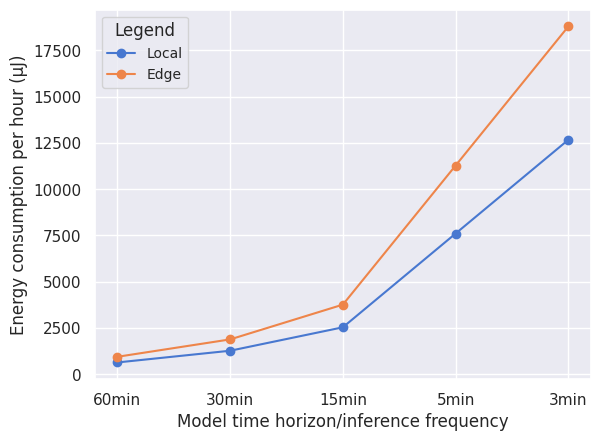

In [ ]:
import matplotlib.pyplot as plt
plt.plot(inf_freq, micro_J_per_hour_local, marker='o', label="Local")
plt.plot(inf_freq, micro_J_per_hour_edge, marker='o', label="Edge")
#plt.plot(inf_freq, snn_micro_J_per_hour_local, marker='o')
#plt.plot(inf_freq, snn_micro_J_per_hour_edge, marker='o')

#plt.xticks([1, 2, 4, 12, 20], ['60min', '30min', '15min', '5min', '3min'])

# Add labels and title
plt.xlabel('Model time horizon/inference frequency')
plt.ylabel('Energy consumption per hour (μJ)')
plt.legend(loc='upper left', fontsize='small', title='Legend')
plt.show()


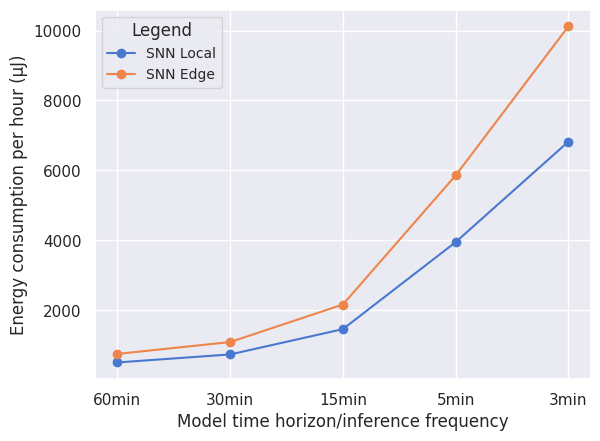

In [ ]:
import matplotlib.pyplot as plt
#plt.plot(inf_freq, micro_J_per_hour_local, marker='o')
#plt.plot(inf_freq, micro_J_per_hour_edge, marker='o')
plt.plot(inf_freq, snn_micro_J_per_hour_local, marker='o', label="SNN Local")
plt.plot(inf_freq, snn_micro_J_per_hour_edge, marker='o', label="SNN Edge")

#plt.xticks([1, 2, 4, 12, 20], ['60min', '30min', '15min', '5min', '3min'])

# Add labels and title
plt.xlabel('Model time horizon/inference frequency')
plt.ylabel('Energy consumption per hour (μJ)')
plt.legend(loc='upper left', fontsize='small', title='Legend')
plt.show()